# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter

from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})
import mlflow
from collections import defaultdict
from scipy.stats import zscore

# original library

import common as com
import pytorch_modeler as modeler
from pytorch_model import LSTM_AutoEncoder as Model
from pytorch_utils import filtered_load_model
import models

import librosa
import IPython
import librosa.display

## load config and set logger

In [4]:
#with open("./config.yaml", 'rb') as f:
#    config = yaml.load(f)

log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '00_train.py')

/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Setting

In [5]:
# Setting seed
modeler.set_seed(42)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_path = INPUT_ROOT + "/dev_data"
add_dev_path = INPUT_ROOT + "/add_dev_data"
# machine type
MACHINE_TYPE = config['IO_OPTION']['MACHINE_TYPE']
machine_types = os.listdir(dev_path)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
PKL_DIR = OUTPUT_ROOT + '/pkl'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(PKL_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/working/research/dcase2020/result/2D/LSTM3CNN_AE_tune2/config.yaml'

## make path list and train/valid split

In [7]:
############################################################################
# make path set and train/valid split
############################################################################
'''
train_paths[machine_type]['train' or 'valid'] = path
'''
dev_train_paths = {}
add_train_paths = {}
train_paths = {}

In [8]:
for machine_type in machine_types:
    # dev train
    dev_train_paths = ["{}/{}/train/".format(dev_path, machine_type) + file for file in os.listdir("{}/{}/train".format(dev_path, machine_type))]
    dev_train_paths = sorted(dev_train_paths)
    # add_dev train
    add_train_paths = ["{}/{}/train/".format(add_dev_path, machine_type) + file for file in os.listdir("{}/{}/train".format(add_dev_path, machine_type))]
    add_train_paths = sorted(add_train_paths)
    # valid
    dev_valid_paths = ["{}/{}/test/".format(dev_path, machine_type) + file for file in os.listdir("{}/{}/test".format(dev_path, machine_type))]
    dev_valid_paths = sorted(dev_valid_paths)
    
    train_paths[machine_type] = {}
    train_paths[machine_type]['train'] = dev_train_paths + add_train_paths
    train_paths[machine_type]['valid'] = dev_valid_paths

## training

In [9]:
#############################################################################
# run
#############################################################################
def run(machine_type):
    com.tic()
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dev_train_paths
    dataloaders_dict = modeler.make_dataloader(train_paths, machine_type)
    # define writer for tensorbord
    os.makedirs(TB_DIR+'/'+machine_type, exist_ok=True)         # debug
    tb_log_dir = TB_DIR + '/' + machine_type
    writer = SummaryWriter(log_dir = tb_log_dir)
    logger.info('TRAINING')
    # parameter setting
    net = Model(sample_rate=config['preprocessing']['sample_rate'],
                window_size=config['preprocessing']['window_size'],
                hop_size=config['preprocessing']['hop_size'],
                mel_bins=config['preprocessing']['mel_bins'],
                fmin=config['preprocessing']['fmin'],
                fmax=config['preprocessing']['fmax'])
    #pretrained_dict = torch.load(config['IO_OPTION']['PREMODEL_PATH'])
    #net = filtered_load_model(net, pretrained_dict)
    num_epochs = config['fit']['num_epochs']
    optimizer = optim.Adam(net.parameters(), lr=1e-2)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
                                              max_lr=1e-2, epochs=num_epochs, steps_per_epoch=len(dataloaders_dict['train']))
    criterion = nn.MSELoss()
    #num_epochs = config['fit']['num_epochs']
    history = modeler.train_net(net, dataloaders_dict, criterion, optimizer, scheduler, num_epochs, writer)
    # output
    model = history['model']
    model_out_path = MODEL_DIR+'/{}_model.pth'.format(machine_type)
    torch.save(model.state_dict(), model_out_path)
    logger.info('\n success:{0} \n'.format(machine_type) + \
                    'model_out_path ==> \n {0}'.format(model_out_path))
    #  close writer for tensorbord
    writer.close()
    #modeler.mlflow_log(history, config, machine_type, model_out_path, tb_log_dir)
    com.toc()
    return history

In [10]:
machine_types

['fan', 'pump', 'slider', 'ToyCar', 'ToyConveyor', 'valve']

2020-11-11 19:49:21,452 - 00_train.py - INFO - TARGET MACHINE_TYPE: fan
2020-11-11 19:49:21,453 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-11 19:49:22,348 - 00_train.py - INFO - TRAINING


use: cuda:0


100%|██████████| 1803/1803 [00:34<00:00, 51.76it/s]


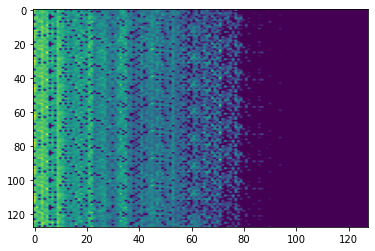

2020-11-11 19:51:45,333 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:971.163817, valid_AUC:0.518493, valid_pAUC:0.502682
100%|██████████| 1803/1803 [00:33<00:00, 53.07it/s]
2020-11-11 19:54:05,758 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:964.314707, valid_AUC:0.519546, valid_pAUC:0.502635
100%|██████████| 1803/1803 [00:34<00:00, 52.71it/s]
2020-11-11 19:56:25,363 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:955.110645, valid_AUC:0.519802, valid_pAUC:0.502570
100%|██████████| 1803/1803 [00:33<00:00, 53.43it/s]
2020-11-11 19:58:43,662 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:938.876106, valid_AUC:0.519973, valid_pAUC:0.502617
100%|██████████| 1803/1803 [00:34<00:00, 52.31it/s]
2020-11-11 20:01:04,019 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:913.274088, valid_AUC:0.518901, valid_pAUC:0.502429
100%|██████████| 1803/1803 [00:36<00:00, 49.25it/s]
2020-11-11 20:03:28,319 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:878.138343, valid_

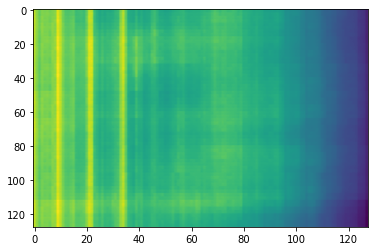

2020-11-11 20:12:53,098 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:681.404882, valid_AUC:0.524865, valid_pAUC:0.503273
100%|██████████| 1803/1803 [00:34<00:00, 51.98it/s]
2020-11-11 20:15:12,992 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:631.496775, valid_AUC:0.529786, valid_pAUC:0.503048
100%|██████████| 1803/1803 [00:34<00:00, 52.20it/s]
2020-11-11 20:17:32,111 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:585.125345, valid_AUC:0.535229, valid_pAUC:0.502692
100%|██████████| 1803/1803 [00:34<00:00, 52.19it/s]
2020-11-11 20:19:51,132 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:551.104428, valid_AUC:0.526066, valid_pAUC:0.502560
 25%|██▌       | 26/102 [00:27<01:19,  1.05s/it]


KeyboardInterrupt: 

In [11]:
for machine_type in machine_types:
    history = run(machine_type)
    with open('{}/{}_history.pkl'.format(PKL_DIR, machine_type), 'wb') as file:
        pickle.dump(history , file)

history = run('ToyCar')
with open('{}/{}_history.pkl'.format(PKL_DIR, machine_type), 'wb') as file:
    pickle.dump(history , file)